In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rio
import seaborn as sns

In [2]:
inputData = 'kernelPCA_clip'
n_clusters = 7
clusters = rio.open_rasterio('Rasters/kmenas_'+inputData+'_'+str(n_clusters)+'.tif')
pca      = rio.open_rasterio('Rasters/'+inputData+'.tif')
#pca      = rio.open_rasterio('Rasters/rmseAll.tif')
#clusters = rio.open_rasterio('Rasters/kmenas_autoencoders_3.tif')
#pca      = rio.open_rasterio('Rasters/autoencoders.tif')

In [3]:
# 3D xarray to 2D xarray
def _flatted(x):
    x = x.stack(z=('y','x'))
    return  x.transpose('z', 'band')

cluster_flat = _flatted(clusters)
pca_flat     = _flatted(pca)
# get index of rows with no data in cluster_flat
no_data = cluster_flat.isnull().any(axis=1)
# if luster_flat.shape not equal to pca_flat.shape, reproject pca_flat
if cluster_flat.shape != pca_flat.shape:
    pca = pca.rio.reproject_match(clusters)
    cluster_flat = _flatted(clusters)
    pca_flat     = _flatted(pca)

# select rows with no data in cluster_flat
cluster_flat = cluster_flat[~no_data]
# select same rows in pca_flat
pca_flat = pca_flat[~no_data]

print('the shape of the cluster is   ', cluster_flat.shape)
print('the shape of the predictor is ', pca_flat.shape)

the shape of the cluster is    (1913870, 1)
the shape of the predictor is  (1913870, 3)


In [5]:
# merge cluster_flat and pca_flat using numpy
df = np.concatenate((cluster_flat.values, pca_flat.values), axis=1)

# df to pandas dataframe
df_pd = pd.DataFrame(df)
# add column names
df_pd.columns = ['cluster', 'PC1', 'PC2',  'PC3']#['cluster', *pca.attrs['long_name']]
df_pd.head()

,cluster,PC1,PC2,PC3
0,3.0,0.451802,0.321989,0.012963
1,3.0,0.458227,0.316086,0.000980
2,4.0,0.529176,0.244217,-0.099721
3,4.0,0.567135,0.213028,-0.147516
4,4.0,0.553467,0.220757,-0.125828


In [13]:
# save df_pd to csv
#df_pd.to_csv('data/clusters_'+inputData+'_'+str(n_clusters)+'.csv', index=False)
#df_pd.to_csv('data/clusters_rmse.csv', index=False)

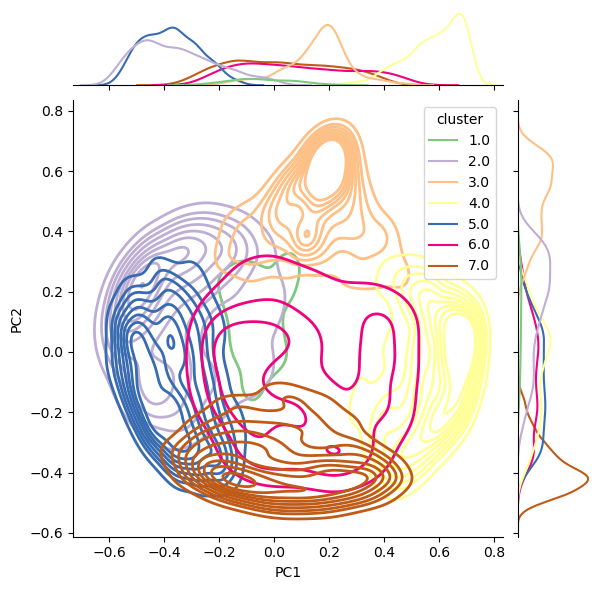

In [6]:
# select 5000 random rows from df_pd
df_pd_random = df_pd.sample(n=5000, random_state=1)
col = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#bf5b17']
# add sns scaterplot with light gey dots

#g = sns.JointGrid(data=df_pd_random, x="PC1", y="PC2")
#g.plot_joint(sns.scatterplot, color='#d3d3d3', edgecolor='#d3d3d3')
#g.plot_joint(sns.kdeplot)
#g.plot_marginals(sns.kdeplot)
#g.plot(sns.kdeplot, palette=col, hue='cluster', marginal_func='kde', linewidths=2)

g = sns.jointplot(
    data=df_pd_random,
    x="PC1", y="PC2", hue="cluster",
    kind="kde",
    palette=col,
    linewidths=2,
    fill=False,
    zorder=2,
)

# save figure
#g.savefig('figures/clusters'+'_'+inputData+'_'+str(n_clusters)+'.svg')

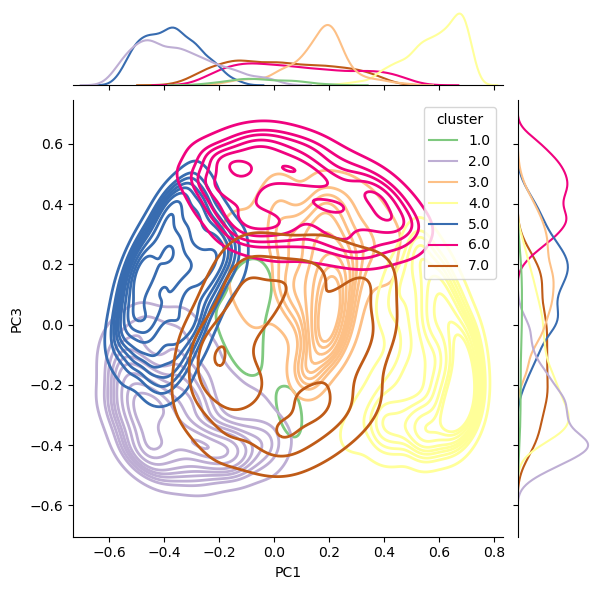

In [7]:
g = sns.jointplot(
    data=df_pd_random,
    x="PC1", y="PC3", hue="cluster",
    kind="kde",
    palette=col,
    linewidths=2,
    fill=False,
    zorder=2,
)


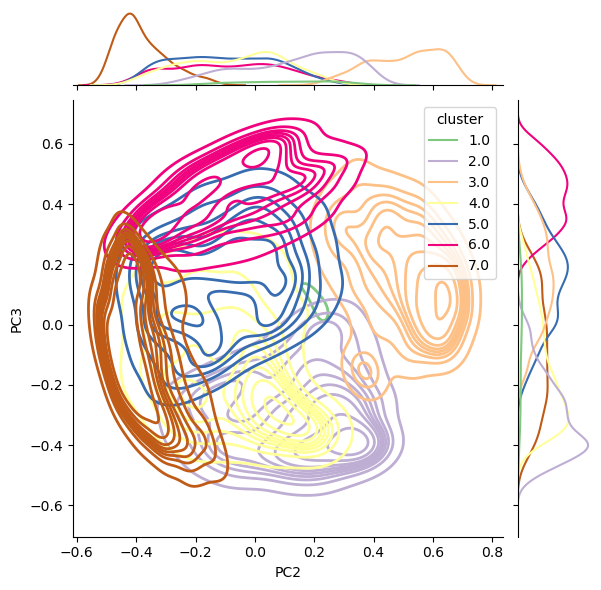

In [8]:
g = sns.jointplot(
    data=df_pd_random,
    x="PC2", y="PC3", hue="cluster",
    kind="kde",
    palette=col,
    linewidths=2,
    fill=False,
    zorder=2,
)


### Rasterize shapfile with PFT information

In [59]:
gdf = gpd.read_file("SHP/Suisun_PFT_diss_proj.shp")

# add new column to gdf with unique values from PFT
gdf['PFT_num'] = gdf['PFT'].astype('category').cat.codes
gdf['PFT_num']

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
Name: PFT_num, dtype: int8

In [61]:
# show gdf['PFT'] and gdf['PFT_num'] side by side
id_names = pd.concat([gdf['PFT'], gdf['PFT_num']], axis=1)
id_names

,PFT,PFT_num
0,Agriculture,0
1,Annual Grassland,1
2,Barren,2
3,Other,3
4,Perennial Grassland,4
5,Pickleweed-Cordgrass-Saltbush,5
6,Tule-Cattail,6
7,Urban or developed,7
8,Water,8
9,Wet Meadows,9


In [73]:
# save gdf to disk
gdf.to_file("SHP/Suisun_PFT_diss_proj_num.shp")

In [ ]:
# rasterize shapefile of PFT classes usin geocube
from geocube.api.core import make_geocube

out_grid = make_geocube(
    vector_data="SHP/Suisun_PFT_diss_proj_num.shp",
    measurements=["PFT_num"],
    resolution=(-10, 10),
)
out_grid#["PFT_num"].rio.to_raster("Rasters/PFT.tif")

In [100]:
# resample size of out_grid using cluster raster
out_grid = out_grid.PFT_num.rio.reproject_match(clusters)
out_grid.rio.to_raster("Rasters/PFT.tif")

In [98]:
# flatten out_grid
out_grid_flat = out_grid.stack(z=('y','x'))
out_grid_flat = out_grid_flat[~no_data]

In [110]:
# merge cluster_flat and out_grid_flat using numpy
df = np.concatenate((cluster_flat.values, out_grid_flat.expand_dims('band').transpose('z', 'band').values), axis=1)

In [111]:
# df to pandas dataframe
df_pd = pd.DataFrame(df)
# add column names
df_pd.columns = ['cluster', 'PFT']
# add value to cluster clumn to avoid zeros
df_pd['cluster'] = df_pd['cluster'] + 1

# save df_pd to csv
df_pd.to_csv('clusters_PFT.csv', index=False)

#### concat all info

In [8]:
## merge all dataframes together 
pft = pd.read_csv('clusters_PFT.csv')
pca = pd.read_csv('clusters_kernelPCA_clip_7.csv')
pheno = pd.read_csv('clusters_phenoshape.csv')
lsp = pd.read_csv('clusters_LSP.csv')
dem = pd.read_csv('clusters_dem.csv')

In [9]:
# concat pft and pca
df = pd.concat([pft.PFT,
                pca,
                lsp.iloc[:, 1:],
                pheno.iloc[:, 1:],
                dem.dem],
               axis=1)
df.head()

,PFT,cluster,PC1,PC2,PC3,sos,pos,eos,vsos,vpos,...,44,45,46,47,48,49,50,51,52,dem
0,1.0,3.0,0.451802,0.321989,0.012963,61.0,96.0,174.0,0.788214,0.993348,...,0.205831,0.209832,0.200719,0.183761,0.236985,0.303679,0.307370,0.443136,0.217868,2754.0
1,1.0,3.0,0.458227,0.316086,0.000980,61.0,96.0,181.0,0.808278,1.081508,...,0.183178,0.183279,0.184772,0.183055,0.249474,0.295069,0.298726,0.367077,0.211366,2675.0
2,1.0,4.0,0.529176,0.244217,-0.099721,61.0,96.0,174.0,1.107876,1.416620,...,0.196790,0.196705,0.187395,0.184437,0.276147,0.345520,0.354517,0.505280,0.222419,2924.0
3,1.0,4.0,0.567135,0.213028,-0.147516,61.0,96.0,174.0,1.229272,1.549733,...,0.214007,0.212883,0.208160,0.210620,0.295528,0.359184,0.385849,0.497093,0.327612,3004.0
4,1.0,4.0,0.553467,0.220757,-0.125828,61.0,96.0,174.0,1.168922,1.492999,...,0.214685,0.195989,0.200513,0.211990,0.283997,0.339289,0.410836,0.454260,0.484751,3110.0


In [10]:
df.to_csv('All_variables.csv', index=False)